In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from data import read_data
from utils import add_noise_est, normalize, add_noise, squeeze_patches

from model_mwcnn import MWCNN
from model_baseline import Unet
from model_kpn import KPN, LossFunc, LossBasic, LossBasicSymetric 
from model_mwkpn import MWKPN
from model_global_dfn import GDFN

gpu_ok = tf.test.is_gpu_available()
print("tf version:", tf.__version__)
print("use GPU:", gpu_ok)

tf version: 2.0.0
use GPU: True


In [2]:
seed = 42
np.random.seed(seed)

# 1. DIV2K data

# 2. Ultrasound data

In [3]:
(train_X_p, train_Y_p), (test_X_p, test_Y_p) = read_data('ultrasound')
N_ims= len(train_X_p)

train_X_p, label_train_X_p = squeeze_patches(train_X_p)
train_Y_p, label_train_Y_p = squeeze_patches(train_Y_p)
test_X_p, label_test_X_p = squeeze_patches(test_X_p)
test_Y_p, label_test_Y_p = squeeze_patches(test_Y_p)

train_X_p = train_X_p[:,np.newaxis,...,np.newaxis]
train_Y_p = train_Y_p[...,np.newaxis]
test_X_p = test_X_p[:,np.newaxis,...,np.newaxis]
test_Y_p = test_Y_p[...,np.newaxis]

print('\nTrain data:')
print('train_X_p:',train_X_p.shape)
print('train_Y_p:',train_Y_p.shape)

print('\nTest data:')
print('test_X_p:',test_X_p.shape)
print('test_Y_p:',test_Y_p.shape)

Totally 1101 images loaded for X and 1101 images loaded for Y
Totally 150 images loaded for X and 150 images loaded for Y

Train data:
train_X_p: (8772, 1, 128, 128, 1)
train_Y_p: (8772, 128, 128, 1)

Test data:
test_X_p: (1134, 1, 128, 128, 1)
test_Y_p: (1134, 128, 128, 1)


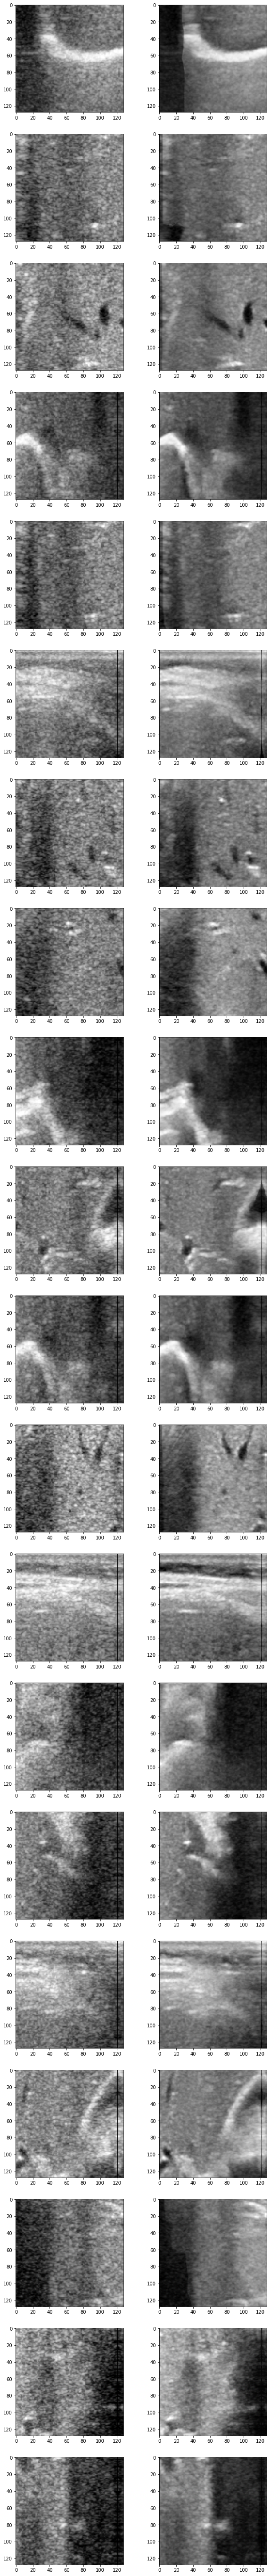

In [4]:
'''Visualization'''
N_show = 20

plt.figure(figsize = (10,5*N_show))
for i in range(N_show):
    n = np.random.randint(test_X_p.shape[0], size = 1)

    plt.subplot(N_show, 2, 2*i+1)
    plt.imshow(train_X_p[n][...,0].squeeze(), cmap='gray')
    #plt.title('noise map std: {:.3f}'.format(train_X_p[n][...,1].std()))
    
    plt.subplot(N_show, 2, 2*i+2)
    plt.imshow(train_Y_p[n].squeeze(), cmap='gray')
    
#plt.savefig('exemple.png')    
plt.show()

In [5]:
print(test_X_p.mean(), test_X_p.std(), test_X_p.min(), test_X_p.max())
print(test_Y_p.mean(), test_Y_p.std(), test_Y_p.min(), test_Y_p.max())

0.3899418 0.2204258 0.0 1.0
0.38655746 0.21317317 0.0 1.0


In [6]:
use_noise_map = False   # if True, concatenate a noise map to the input
#use_noise_est = False   # if True, use a model to estimate noise map, if False, use known info

if not use_noise_map:
    train_X_p = train_X_p[...,0][..., np.newaxis]
    test_X_p = test_X_p[...,0][..., np.newaxis]

#train_X_p = train_X_p.squeeze(1)
#test_X_p = test_X_p.squeeze(1)
    
print('Train data:')
print('train_X_p:',train_X_p.shape)
print('train_Y_p:',train_Y_p.shape)

print('\nTest data:')
print('test_X_p:',test_X_p.shape)
print('test_Y_p:',test_Y_p.shape)

Train data:
train_X_p: (8772, 1, 128, 128, 1)
train_Y_p: (8772, 128, 128, 1)

Test data:
test_X_p: (1134, 1, 128, 128, 1)
test_Y_p: (1134, 128, 128, 1)


In [7]:
N_train = train_X_p.shape[0]
N_test = test_X_p.shape[0]

# training hyperparameters
batch_size = 16
lr = 3e-4
epochs = 30
training_steps = int(epochs*N_train/batch_size)
display_step = int(training_steps/epochs*0.66)

print(training_steps)
print(display_step)

16447
361


In [8]:
# Use tf.data API to shuffle and batch data.
train_dataset = tf.data.Dataset.from_tensor_slices((train_X_p,train_Y_p))
train_dataset = train_dataset.repeat().shuffle(5000).batch(batch_size).prefetch(1)

test_dataset = tf.data.Dataset.from_tensor_slices((test_X_p,test_Y_p))
test_dataset = test_dataset.batch(batch_size).prefetch(1)

# Test directly the div2k data with the exsting model

In [9]:
# model
#model = Unet(color = False, kernel_size=7, channel_att=False, spatial_att=True, if_wavelet=False)
#model = MWCNN(color = False, kernel_size=5, channel_att=False, spatial_att=False)
model = KPN(color=False, burst_length=1, blind_est=True, sep_conv=False, kernel_size=[3],
            channel_att=False, spatial_att=True, core_bias=True, use_bias=True)
#model = MWKPN(color=False, burst_length=1, blind_est=True, sep_conv=False, kernel_size=[3,5,7],
#             channel_att=False, spatial_att=True, core_bias=True, use_bias=True)

sub_dir = 'transfer_to_div2k'
#filename = 'unet_satt_bias_combinedloss'
filename = 'kpn_ks357_satt_bias_combinedsymetricloss_transfered'

load_model = False
if load_model:
    model.load_weights(filepath = "model_weights/" + sub_dir + '/' + filename + ".ckpt")
    
sub_dir = 'transfer_to_ultrasound'
filename = 'kpn_ks3_satt_bias_combinedloss'

In [10]:
# optimizer
optimizer = tf.keras.optimizers.Adam(lr)
#optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)

# loss func
#loss_func = tf.keras.losses.MeanAbsoluteError()
#loss_func = tf.keras.losses.MeanSquaredError()
loss_func = LossBasic(gradient_L1 = True)
#loss_func = LossBasicSymetric(gradient_L1 = True, gamma = 10)

***Comments:***

The model with noise estiation performs better than The biasfree model, which performs better than the pure model. 

# Train the model with the div2k data

In [11]:
# optimization process
def lr_fn(step, cur_lr):
    if step * batch_size // N_train < 10:
        '''warm up, if not, the model will easily reach a local convergence for these complicated data'''
        return cur_lr
    else:
        '''exponetial'''
        next_epoch = step * batch_size // N_train - (step-1) * batch_size // N_train
        return cur_lr * (0.95**next_epoch)

def run_optimization(step, train_X, train_Y):
    with tf.GradientTape() as g:
        #pred_Y = model(train_X) 
        pred_Y, _, core = model(train_X, tf.expand_dims(train_X[...,0], axis=-1))
        
#         batch_size, N, height, width, color = tf.expand_dims(train_X[...,0], axis=-1).shape 
#         core, _ = model.kernel_pred._convert_dict(core, batch_size, N, height, width, color)
#         loss = loss_func(pred_Y, train_Y, core)
        loss = loss_func(pred_Y, train_Y)
    
    gradients = g.gradient(loss, model.trainable_variables)
    optimizer.learning_rate = lr_fn(step, optimizer.learning_rate.numpy())
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

In [12]:
# 发现用tensorboard summary会让速度变得很慢很慢
train_losses = []
test_losses = []
test_steps = []
lrs = []

In [ ]:
mean_train_loss = total_train = 0
for step, (batch_X, batch_Y) in enumerate(train_dataset.take(training_steps), start = 1):
    train_loss = run_optimization(step, batch_X, batch_Y)
    
    mean_train_loss +=  train_loss.numpy()
    total_train += 1
    train_losses.append(train_loss.numpy())
    lrs.append(optimizer.lr.numpy())
    
    if step % display_step == 0:
        mean_test_loss = total_test = 0
        for (batch_test_X, batch_test_Y) in test_dataset:
            #pred_test_Y = model(batch_test_X)
            pred_test_Y, _, core = model(batch_test_X, tf.expand_dims(batch_test_X[...,0],axis=-1))
            
#             batch_size, N, height, width, color = tf.expand_dims(batch_test_X[...,0], axis=-1).shape 
#             core, _ = model.kernel_pred._convert_dict(core, batch_size, N, height, width, color)
#             test_loss = loss_func(pred_test_Y, batch_test_Y, core)
            test_loss = loss_func(pred_test_Y, batch_test_Y)
            
            mean_test_loss += test_loss.numpy()
            total_test += 1
        
        mean_test_loss /= total_test
        mean_train_loss /= total_train
        test_losses.append(mean_test_loss)
        test_steps.append(step)

        print("step: {:3d}/{:3d} || train loss: {:.5f} || test loss: {:.5f}"
              .format(step, training_steps, mean_train_loss, mean_test_loss))
        
        mean_train_loss = total_train = 0

step: 361/16447 || train loss: 0.02100 || test loss: 0.01695
step: 722/16447 || train loss: 0.01499 || test loss: 0.01616
step: 1083/16447 || train loss: 0.01445 || test loss: 0.01596
step: 1444/16447 || train loss: 0.01423 || test loss: 0.01549
step: 1805/16447 || train loss: 0.01391 || test loss: 0.01555
step: 2166/16447 || train loss: 0.01390 || test loss: 0.01552
step: 2527/16447 || train loss: 0.01385 || test loss: 0.01526
step: 2888/16447 || train loss: 0.01360 || test loss: 0.01556
step: 3249/16447 || train loss: 0.01365 || test loss: 0.01549
step: 3610/16447 || train loss: 0.01350 || test loss: 0.01518
step: 3971/16447 || train loss: 0.01341 || test loss: 0.01528
step: 4332/16447 || train loss: 0.01349 || test loss: 0.01514
step: 4693/16447 || train loss: 0.01331 || test loss: 0.01510
step: 5054/16447 || train loss: 0.01332 || test loss: 0.01530
step: 5415/16447 || train loss: 0.01327 || test loss: 0.01525
step: 5776/16447 || train loss: 0.01318 || test loss: 0.01501
step: 6137

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(range(training_steps)[100:], train_losses[100:])
plt.xlabel('steps')
plt.ylabel('value')
plt.title('training loss')

plt.subplot(132)
plt.plot(test_steps[1:], test_losses[1:])
plt.xlabel('steps')
plt.ylabel('value')
plt.title('test loss')

plt.subplot(133)
plt.plot(range(training_steps), lrs)
plt.xlabel('steps')
plt.ylabel('value')
plt.title('learning rate')

plt.savefig('./logs/' + sub_dir + '/' + filename + '_' + current_time + '.png')
plt.show()

In [ ]:
total_test_loss = []
for (batch_test_X, batch_test_Y) in test_dataset:
    #pred_test_Y = model(batch_test_X)
    pred_test_Y, _, core = model(batch_test_X, tf.expand_dims(batch_test_X[...,0], axis=-1))
    
#     batch_size, N, height, width, color = tf.expand_dims(batch_test_X[...,0], axis=-1).shape 
#     core, _ = model.kernel_pred._convert_dict(core, batch_size, N, height, width, color)
#     test_loss = loss_func(pred_test_Y, batch_test_Y, core)
    test_loss = loss_func(pred_test_Y, batch_test_Y)
                          
    total_test_loss.append(test_loss.numpy())
total_test_loss = np.mean(total_test_loss)

print("Test data loss: {:.3f}".format(total_test_loss))

In [ ]:
# draw test figures
n_chosen = np.random.randint(test_X_p.shape[0], size = 16)
test_x = test_X_p[n_chosen] 
test_y = test_Y_p[n_chosen] 
#pred_y = model(test_x)
pred_y, _, _ = model(test_x, tf.expand_dims(test_x[...,0], axis=-1))
    
plt.figure(figsize = (15,5*batch_size))
i = 1
    
for n in range(batch_size):
    plt.subplot(batch_size,3,i)
    plt.imshow(test_x[n][...,0].squeeze(), cmap='gray')
    #plt.title('noise var {:.3f}'.format(test_x[n][...,1].mean()))
    plt.axis('off')
    i += 1

    plt.subplot(batch_size,3,i)
    plt.imshow(test_y[n].squeeze(), cmap='gray')
    plt.axis('off')
    i += 1
    
    plt.subplot(batch_size,3,i)
    plt.imshow(pred_y[n].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    i += 1

plt.savefig('./results/images/' + sub_dir + '/' + filename + '_' + current_time + '.png')
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

def error(x1, x2, mode='mse'):
    if mode == 'mse':
        return np.mean(np.square(x1-x2))
    elif mode == 'mae':
        return np.mean(np.abs(x1-x2))
    return

In [ ]:
test_X = []
test_Y = []
pred_Y = []
for inputs, target in test_dataset:
    test_X.append(inputs.numpy())
    test_Y.append(target.numpy())
    
    #outputs = model(inputs)
    outputs, _, _ = model(inputs, tf.expand_dims(inputs[...,0], axis=-1))
    pred_Y.append(outputs.numpy())

test_X = np.concatenate(test_X, axis=0)
test_Y = np.concatenate(test_Y, axis=0)
pred_Y = np.concatenate(pred_Y, axis=0)

print('Evaluation of ground truth and noised images:')
print('psnr:{:.3f}\tssmi:{:.3f}\tmse:{:.3f}'.format(psnr(test_X[..., 0].squeeze(), test_Y.squeeze(), data_range=1), 
                                        ssim(test_X[..., 0].squeeze(), test_Y.squeeze(), data_range=1),
                                        error(test_X[..., 0].squeeze(), test_Y.squeeze())))

print('\nEvaluation of recovered images and noised images:')
print('psnr:{:.3f}\tssmi:{:.3f}\tmse:{:.3f}'.format(psnr(pred_Y, test_Y, data_range=1), 
                                        ssim(pred_Y.squeeze(), test_Y.squeeze(), data_range=1),
                                        error(pred_Y, test_Y)))

print('\nGround Truth:')
print('max:{:.3f}\tmin:{:.3f}\tmean:{:.3f}'.format(test_Y.max(), test_Y.min(), test_Y.mean()))

print('\nNoised images:')
print('max:{:.3f}\tmin:{:.3f}\tmean:{:.3f}'.format(test_X[..., 0].max(), test_X[..., 0].min(), test_X.mean()))

print('\nRecoverd images:')
print('max:{:.3f}\tmin:{:.3f}\tmean:{:.3f}'.format(pred_Y.max(), pred_Y.min(), pred_Y.mean()))

In [ ]:
# Save TF model.
model.save_weights(filepath = "model_weights/" + sub_dir + "/" + filename + ".ckpt")